In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/restaurant-reviews/postcovid_reviews.csv
/kaggle/input/restaurant-reviews/precovid_reviews.csv


In [3]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812364 sha256=bd988b57254f37d28cd3809e48a87bcccd1fa03ff5901aa279f3e17e41eaa172
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("RestaurantReviews") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/14 04:56:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Read the CSV files into Spark DataFrames
df_post = spark.read.csv('/kaggle/input/restaurant-reviews/postcovid_reviews.csv', header=True, inferSchema=True)
df_pre = spark.read.csv('/kaggle/input/restaurant-reviews/precovid_reviews.csv', header=True, inferSchema=True)

In [6]:
# Show the first few rows of each DataFrame
df_post.show()
df_pre.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|         business_id|                name|             address|              state_|                city|         postal_code|            latitude|           longitude|               stars|        review_count|             is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------

In [7]:
df_pre.printSchema()
df_post.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state_: string (nullable = true)
 |-- city: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- is_open: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- customer_stars: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- text_: string (nullable = true)
 |-- date_: string (nullable = true)

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state_: string (nullable = true)
 |-- ci

# **Data Pre-processing**

**Convert Date Columns**

In [8]:
from pyspark.sql.functions import col
from pyspark.sql.types import DateType

# Try converting 'date_' column to DateType and filter out invalid years
# Let's assume valid years range from 1900 to 2100 (adjust as necessary)

# First, keep rows where year is within a reasonable range
df_pre = df_pre.filter((col("date_").substr(1, 4).cast("int") >= 1900) & 
                         (col("date_").substr(1, 4).cast("int") <= 2100))

# Then, convert the 'date_' column to DateType
df_pre = df_pre.withColumn("date_", col("date_").cast(DateType()))

# Define the start and end dates
start_date = "2018-01-01"
end_date = "2019-12-31"

# Filter the cleaned DataFrame based on the date range
df_pre = df_pre.filter((col("date_") >= start_date) & (col("date_") <= end_date))

# Show the filtered DataFrame
df_pre.show()



+--------------------+--------------------+--------------------+------+-----------------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+
|         business_id|                name|             address|state_|             city|postal_code|          latitude|          longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|     date_|
+--------------------+--------------------+--------------------+------+-----------------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+
|KXCXaF5qimmtKKqnP...|             Thierry| 1059 

In [9]:
# Then, convert the 'date_' column to DateType
df_post = df_post.withColumn("date_", col("date_").cast(DateType()))

# Define the start and end dates
start_date = "2020-01-01"
end_date = "2021-01-27"

# Filter the cleaned DataFrame based on the date range
df_post = df_post.filter((col("date_") >= start_date) & (col("date_") <= end_date))

# Show the filtered DataFrame
df_post.show()

+--------------------+--------------------+--------------------+------+----------+-----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+
|         business_id|                name|             address|state_|      city|postal_code|     latitude|     longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|     date_|
+--------------------+--------------------+--------------------+------+----------+-----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+
|imUlMANF0tNDxWOXd...|Donut Express & C...|         258 Main St|    MA|  Medfield|      02052|   42.

In [10]:
# Show the schema to verify the changes
df_post.printSchema()
df_pre.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state_: string (nullable = true)
 |-- city: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- is_open: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- customer_stars: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- text_: string (nullable = true)
 |-- date_: date (nullable = true)

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state_: string (nullable = true)
 |-- city

**Add period Column**

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Create Spark session
spark = SparkSession.builder.appName('CombineDataFrames').getOrCreate()

# Assuming df_pre and df_post are your DataFrames with columns 'date_', 'state', 'sentiment'
# Add a column to indicate the period
df_pre = df_pre.withColumn('period', lit('Pre-COVID'))
df_post = df_post.withColumn('period', lit('Post-COVID'))

24/09/14 04:59:41 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


**Cast columns to IntegerType**

In [12]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col

# Function to cast columns to IntegerType
def cast_columns_to_integer(df, columns):
    for column in columns:
        df = df.withColumn(column, col(column).cast(IntegerType()))
    return df

# List of columns to cast to integer
columns_to_cast = ['stars', 'review_count', 'customer_stars', 'useful', 'funny', 'cool']

# Apply the function to df_pre and df_post
df_pre = cast_columns_to_integer(df_pre, columns_to_cast)
df_post = cast_columns_to_integer(df_post, columns_to_cast)

# Display the schema to check the updated column types
print("Schema for df_pre:")
df_pre.printSchema()

print("Schema for df_post:")
df_post.printSchema()


Schema for df_pre:
root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state_: string (nullable = true)
 |-- city: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- stars: integer (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- is_open: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- customer_stars: integer (nullable = true)
 |-- useful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- cool: integer (nullable = true)
 |-- text_: string (nullable = true)
 |-- date_: date (nullable = true)
 |-- period: string (nullable = false)

Schema for df_post:
root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |

# **Data Cleaning**

**Convert Date Columns**

In [13]:
# Drop columns from the DataFrames
df_post = df_post.drop('address', 'hours', 'postal_code', 'review_id')
df_pre = df_pre.drop('address', 'hours', 'postal_code', 'review_id')

# Show the schema to verify the changes
df_post.printSchema()
df_pre.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- state_: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- stars: integer (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- is_open: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- customer_stars: integer (nullable = true)
 |-- useful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- cool: integer (nullable = true)
 |-- text_: string (nullable = true)
 |-- date_: date (nullable = true)
 |-- period: string (nullable = false)

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- state_: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- stars: integer (nullable = true)
 |-- rev

**Determine missing values**

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum

# Create a Spark session
spark = SparkSession.builder.appName("MissingValues").getOrCreate()



24/09/14 05:00:11 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [16]:
# Count missing values for each column
missing_values = df_pre.select([sum(col(column).isNull().cast("int")).alias(column) for column in df_pre.columns])

# Show the result
missing_values.show()

+-----------+----+------+----+--------+---------+-----+------------+-------+----------+-------+--------------+------+-----+----+-----+-----+------+
|business_id|name|state_|city|latitude|longitude|stars|review_count|is_open|categories|user_id|customer_stars|useful|funny|cool|text_|date_|period|
+-----------+----+------+----+--------+---------+-----+------------+-------+----------+-------+--------------+------+-----+----+-----+-----+------+
|          0|   1|     1|   1|       1|        1|   25|          25|      1|         0|      0|            25|    25|   25|  25|    0|    0|     0|
+-----------+----+------+----+--------+---------+-----+------------+-------+----------+-------+--------------+------+-----+----+-----+-----+------+



In [17]:
# Drop columns with any missing (null) values
df_pre = df_pre.dropna(how="any", subset=df_pre.columns)

# Show the resulting DataFrame
df_pre.show()


+--------------------+--------------------+------+-----------------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+---------+
|         business_id|                name|state_|             city|          latitude|          longitude|stars|review_count|is_open|          categories|             user_id|customer_stars|useful|funny|cool|               text_|     date_|   period|
+--------------------+--------------------+------+-----------------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+---------+
|KXCXaF5qimmtKKqnP...|             Thierry|    BC|        Vancouver|        49.2848765|       -123.1226288|    4|         849|      1|Food, Desserts, C...|JHXQEayrDHOWGexs0...|             1|     0|    0|   0|Great coffee and ...|2018-03-03|Pre

In [18]:
# Count missing values for each column
missing_values = df_post.select([sum(col(column).isNull().cast("int")).alias(column) for column in df_post.columns])

# Show the result
missing_values.show()

+-----------+----+------+----+--------+---------+-----+------------+-------+----------+-------+--------------+------+-----+----+-----+-----+------+
|business_id|name|state_|city|latitude|longitude|stars|review_count|is_open|categories|user_id|customer_stars|useful|funny|cool|text_|date_|period|
+-----------+----+------+----+--------+---------+-----+------------+-------+----------+-------+--------------+------+-----+----+-----+-----+------+
|          0|   0|     0|   0|       0|        0|    7|           7|      0|         0|      0|             7|     7|    7|   7|    0|    0|     0|
+-----------+----+------+----+--------+---------+-----+------------+-------+----------+-------+--------------+------+-----+----+-----+-----+------+



In [16]:
# Drop columns with any missing (null) values
df_post = df_post.dropna(how="any", subset=df_post.columns)

# Show the resulting DataFrame
df_post.show()


+--------------------+--------------------+------+----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+
|         business_id|                name|state_|      city|     latitude|     longitude|stars|review_count|is_open|          categories|             user_id|customer_stars|useful|funny|cool|               text_|     date_|
+--------------------+--------------------+------+----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+
|imUlMANF0tNDxWOXd...|Donut Express & C...|    MA|  Medfield|   42.1937214|   -71.2902513|    5|          42|      1|Food, Bakeries, C...|os_bbAergdkI_OiYy...|             2|     0|    0|   0|The last custom c...|2020-12-24|
|VaZPHQuklOlvZcj0H...|       Norwood Spice|    MA|   Norwood|    42.193486|    -71.201524|  4.5|    

**Remove Duplicates**

In [19]:
# Drop duplicates in df_pre
df_pre = df_pre.dropDuplicates()

# Drop duplicates in df_post
df_post = df_post.dropDuplicates()


In [20]:
# Show the resulting DataFrames
df_pre.show()
df_post.show()

+--------------------+--------------------+------+----------------+------------------+------------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+---------+
|         business_id|                name|state_|            city|          latitude|         longitude|stars|review_count|is_open|          categories|             user_id|customer_stars|useful|funny|cool|               text_|     date_|   period|
+--------------------+--------------------+------+----------------+------------------+------------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+---------+
|6W_Dcu-kcPa4QzwDg...|Wilfs Restaurant ...|    OR|        Portland|     45.5286288551|   -122.6762887139|    3|         258|      1|American (New), A...|ubSUaP5vKfnhSFS90...|             2|     1|    0|   0|Service was wonde...|2018-03-05|Pre-COVID|


+--------------------+--------------------+------+---------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+----------+
|         business_id|                name|state_|     city|     latitude|      longitude|stars|review_count|is_open|          categories|             user_id|customer_stars|useful|funny|cool|               text_|     date_|    period|
+--------------------+--------------------+------+---------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+----------+
|0VRl8_1TnXNq1Uoco...|             Dunkin'|    FL| Maitland|   28.6137748|    -81.3655606|    3|          38|      1|Breakfast & Brunc...|v5WQ_3MRMNOzi-aih...|             2|     0|    0|   0|This is the 3rd t...|2020-12-05|Post-COVID|
|1b-SIUJttFwlFWTfp...|Tassili's Raw Rea...|    GA|  Atla

**Standardize Text Fields**

In [21]:
from pyspark.sql.functions import upper

# Convert 'state_' column to uppercase in df_pre
df_pre = df_pre.withColumn('state_', upper(df_pre['state_']))

# Convert 'state_' column to uppercase in df_post
df_post = df_post.withColumn('state_', upper(df_post['state_']))

In [22]:
# Dictionary for the replacement
state_replacements = {
    'KY': 'Kentucky', 'BC': 'British Columbia', 'TX': 'Texas', 'MA': 'Massachusetts', 'GA': 'Georgia',
    'FL': 'Florida', 'OH': 'Ohio', 'OR': 'Oregon', 'WA': 'Washington', 'CO': 'Colorado',
    'NH': 'New Hampshire', 'WY': 'Wyoming', 'VA': 'Virginia', 'ABE': 'British Columbia',
    'MN': 'Minnesota', 'KS': 'Kansas'
}

# Replace values in 'state_' column for df_post
df_post = df_post.replace(state_replacements, subset=['state_'])

# Replace values in 'state_' column for df_pre
df_pre = df_pre.replace(state_replacements, subset=['state_'])



In [23]:
from pyspark.sql.functions import col

# Create a set of valid state names from the dictionary keys
valid_states = set(state_replacements.values())

# Filter rows where 'state_' is in the set of valid states
df_post = df_post.filter(col('state_').isin(valid_states))
df_pre = df_pre.filter(col('state_').isin(valid_states))

# Show the resulting DataFrames
df_post.show()
df_pre.show()


+--------------------+--------------------+----------------+---------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+----------+
|         business_id|                name|          state_|     city|     latitude|      longitude|stars|review_count|is_open|          categories|             user_id|customer_stars|useful|funny|cool|               text_|     date_|    period|
+--------------------+--------------------+----------------+---------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+----------+
|0VRl8_1TnXNq1Uoco...|             Dunkin'|         Florida| Maitland|   28.6137748|    -81.3655606|    3|          38|      1|Breakfast & Brunc...|v5WQ_3MRMNOzi-aih...|             2|     0|    0|   0|This is the 3rd t...|2020-12-05|Post-COVID|
|1b-SIUJttFwlFWT

+--------------------+--------------------+-------------+----------------+------------------+------------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+---------+
|         business_id|                name|       state_|            city|          latitude|         longitude|stars|review_count|is_open|          categories|             user_id|customer_stars|useful|funny|cool|               text_|     date_|   period|
+--------------------+--------------------+-------------+----------------+------------------+------------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+---------+
|6W_Dcu-kcPa4QzwDg...|Wilfs Restaurant ...|       Oregon|        Portland|     45.5286288551|   -122.6762887139|    3|         258|      1|American (New), A...|ubSUaP5vKfnhSFS90...|             2|     1|    0|   0|Service was won

**Split the categories to main_category**

In [24]:
from pyspark.sql.functions import split

df_pre = df_pre.withColumn("main_category", split(col("categories"), ",").getItem(0))
df_post = df_post.withColumn("main_category", split(col("categories"), ",").getItem(0))


In [23]:
# Show the resulting DataFrames
df_post.show()
df_pre.show()

+--------------------+--------------------+----------------+------------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+--------------+
|         business_id|                name|          state_|        city|     latitude|      longitude|stars|review_count|is_open|          categories|             user_id|customer_stars|useful|funny|cool|               text_|     date_| main_category|
+--------------------+--------------------+----------------+------------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+--------------+
|ymJwVeulnh34SSYPX...|The COOP: A South...|         Florida| Winter Park|    28.597366|     -81.357219|  3.5|         796|      1|Soul Food, Comfor...|ZUTaFN6U7zh6CH_Yt...|             5|     1|    1|   1|Loved the take ou...|2020-07-13|    

+--------------------+--------------------+----------------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+--------------------+
|         business_id|                name|          state_|       city|          latitude|          longitude|stars|review_count|is_open|          categories|             user_id|customer_stars|useful|funny|cool|               text_|     date_|       main_category|
+--------------------+--------------------+----------------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+--------------------+
|jMz_y_-cWMfiZF7Q5...|         Ramen Danbo|British Columbia|  Vancouver|     49.2874959132|    -123.1289341673|  4.5|         436|      1|Ramen, Japanese, ...|VKhD_5gOfSd81wtKu...|             5|    

**Verify Date Column Data**

In [24]:
# Show a sample of the data to inspect the date values
df_pre.select("date_").show(10, False)
df_post.select("date_").show(10, False)


+----------+
|date_     |
+----------+
|2018-05-30|
|2018-07-08|
|2018-01-10|
|2018-09-16|
|2018-06-27|
|2018-06-28|
|2018-08-17|
|2018-04-06|
|2018-06-23|
|2018-02-04|
+----------+
only showing top 10 rows



+----------+
|date_     |
+----------+
|2020-07-13|
|2020-01-23|
|2020-02-16|
|2020-02-16|
|2020-08-29|
|2020-10-30|
|2020-03-08|
|2020-03-17|
|2020-05-28|
|2020-01-06|
+----------+
only showing top 10 rows



**Convert date column to proper date format**

In [25]:
from pyspark.sql.functions import col, to_date

# Convert date column to proper date format
df_pre = df_pre.withColumn("date_", to_date(col("date_"), "yyyy-MM-dd"))
df_post = df_post.withColumn("date_", to_date(col("date_"), "yyyy-MM-dd"))

# Check for any null or invalid dates after conversion
df_pre.filter(col("date_").isNull()).show()
df_post.filter(col("date_").isNull()).show()


+-----------+----+------+----+--------+---------+-----+------------+-------+----------+-------+--------------+------+-----+----+-----+-----+------+-------------+
|business_id|name|state_|city|latitude|longitude|stars|review_count|is_open|categories|user_id|customer_stars|useful|funny|cool|text_|date_|period|main_category|
+-----------+----+------+----+--------+---------+-----+------------+-------+----------+-------+--------------+------+-----+----+-----+-----+------+-------------+
+-----------+----+------+----+--------+---------+-----+------------+-------+----------+-------+--------------+------+-----+----+-----+-----+------+-------------+



+-----------+----+------+----+--------+---------+-----+------------+-------+----------+-------+--------------+------+-----+----+-----+-----+------+-------------+
|business_id|name|state_|city|latitude|longitude|stars|review_count|is_open|categories|user_id|customer_stars|useful|funny|cool|text_|date_|period|main_category|
+-----------+----+------+----+--------+---------+-----+------------+-------+----------+-------+--------------+------+-----+----+-----+-----+------+-------------+
+-----------+----+------+----+--------+---------+-----+------------+-------+----------+-------+--------------+------+-----+----+-----+-----+------+-------------+



In [26]:
# Filter out rows with invalid dates
df_pre = df_pre.filter(col("date_").isNotNull())
df_post = df_post.filter(col("date_").isNotNull())


In [27]:
# Show the resulting DataFrames
df_post.show()
df_pre.show()

+--------------------+--------------------+----------------+------------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+--------------+
|         business_id|                name|          state_|        city|     latitude|      longitude|stars|review_count|is_open|          categories|             user_id|customer_stars|useful|funny|cool|               text_|     date_| main_category|
+--------------------+--------------------+----------------+------------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+--------------+
|ymJwVeulnh34SSYPX...|The COOP: A South...|         Florida| Winter Park|    28.597366|     -81.357219|  3.5|         796|      1|Soul Food, Comfor...|ZUTaFN6U7zh6CH_Yt...|             5|     1|    1|   1|Loved the take ou...|2020-07-13|    

+--------------------+--------------------+----------------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+--------------------+
|         business_id|                name|          state_|       city|          latitude|          longitude|stars|review_count|is_open|          categories|             user_id|customer_stars|useful|funny|cool|               text_|     date_|       main_category|
+--------------------+--------------------+----------------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------+------+-----+----+--------------------+----------+--------------------+
|jMz_y_-cWMfiZF7Q5...|         Ramen Danbo|British Columbia|  Vancouver|     49.2874959132|    -123.1289341673|  4.5|         436|      1|Ramen, Japanese, ...|VKhD_5gOfSd81wtKu...|             5|    

# Data Analysis and Visualization

**Sentimetnt Analysis**

In [27]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from textblob import TextBlob

def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

In [28]:
sentiment_udf = udf(sentiment_analysis, FloatType())

df_pre = df_pre.withColumn("sentiment", sentiment_udf(col("text_")))
df_post = df_post.withColumn("sentiment", sentiment_udf(col("text_")))

In [29]:
# Drop columns from the DataFrames
df_post = df_post.drop('text_', 'categories')
df_pre = df_pre.drop('text_', 'categories')

# Show the schema to verify the changes
df_post.printSchema()
df_pre.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- state_: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- stars: integer (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- is_open: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- customer_stars: integer (nullable = true)
 |-- useful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- cool: integer (nullable = true)
 |-- date_: date (nullable = true)
 |-- period: string (nullable = false)
 |-- main_category: string (nullable = true)
 |-- sentiment: float (nullable = true)

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- state_: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- stars: integer (nullable = true)
 |

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Create Spark session
spark = SparkSession.builder.appName('CombineDataFrames').getOrCreate()

# Assuming df_pre and df_post are your DataFrames with columns 'date_', 'state', 'sentiment'
# Add a column to indicate the period
df_pre = df_pre.withColumn('period', lit('Pre-COVID'))
df_post = df_post.withColumn('period', lit('Post-COVID'))

24/09/14 05:05:34 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [31]:
# Combine the DataFrames
df = df_pre.union(df_post)

+--------------------+--------------------+-------------+----------------+------------------+------------------+-----+------------+-------+--------------------+--------------+------+-----+----+----------+---------+--------------------+-----------+
|         business_id|                name|       state_|            city|          latitude|         longitude|stars|review_count|is_open|             user_id|customer_stars|useful|funny|cool|     date_|   period|       main_category|  sentiment|
+--------------------+--------------------+-------------+----------------+------------------+------------------+-----+------------+-------+--------------------+--------------+------+-----+----+----------+---------+--------------------+-----------+
|6W_Dcu-kcPa4QzwDg...|Wilfs Restaurant ...|       Oregon|        Portland|     45.5286288551|   -122.6762887139|    3|         258|      1|ubSUaP5vKfnhSFS90...|             2|     1|    0|   0|2018-03-05|Pre-COVID|      American (New)| 0.29097712|
|3DdXJnG

**Sentiment Analysis for State**

In [52]:
from pyspark.sql.functions import avg, col, lit

def avg_sentiment_by_state(df, period):
    avg_sentiment = df.groupBy("state_").agg(avg("sentiment").alias("avg_sentiment")).withColumn("period", lit(period))
    return avg_sentiment

# Overall Average Sentiment by State
avg_sentiment_overall = avg_sentiment_by_state(df, 'Overall').toPandas()

# Pre-COVID Average Sentiment by State
avg_sentiment_pre = avg_sentiment_by_state(df.filter(col("period") == "Pre-COVID"), 'Pre-COVID').toPandas()

# Post-COVID Average Sentiment by State
avg_sentiment_post = avg_sentiment_by_state(df.filter(col("period") == "Post-COVID"), 'Post-COVID').toPandas()


24/09/14 06:32:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:32:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:32:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:32:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:32:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:32:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:32:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:32:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:32:39 WARN RowBasedKeyValueBatch: Calling spill() on

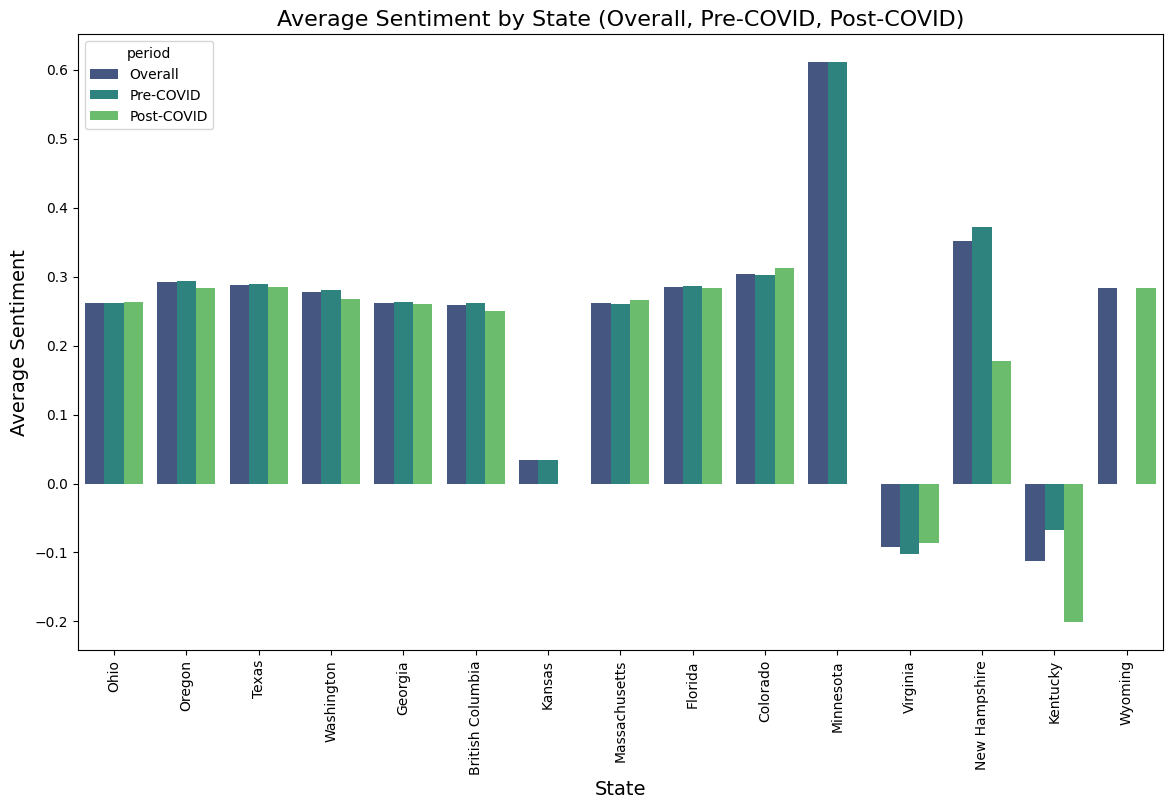

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine the dataframes into one with an additional 'period' column
combined_df = pd.concat([avg_sentiment_overall, avg_sentiment_pre, avg_sentiment_post])

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a seaborn bar plot
sns.barplot(data=combined_df, x='state_', y='avg_sentiment', hue='period', palette='viridis')

# Add titles and labels
plt.title('Average Sentiment by State (Overall, Pre-COVID, Post-COVID)', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Sentiment', fontsize=14)
plt.xticks(rotation=90)  # Rotate x labels for better readability

# Display the plot
plt.show()


In [55]:
from pyspark.sql.functions import lit, avg, col
import pandas as pd

def avg_sentiment_by_state(df, period):
    # Calculate average sentiment by state
    avg_sentiment = df.groupBy("state_").agg(avg("sentiment").alias("avg_sentiment")).withColumn("period", lit(period))
    return avg_sentiment

# Calculate average sentiment for each period
avg_sentiment_overall = avg_sentiment_by_state(df, 'Overall')
avg_sentiment_pre = avg_sentiment_by_state(df.filter(col("period") == "Pre-COVID"), 'Pre-COVID')
avg_sentiment_post = avg_sentiment_by_state(df.filter(col("period") == "Post-COVID"), 'Post-COVID')

# Convert to Pandas DataFrames
avg_sentiment_overall_pd = avg_sentiment_overall.toPandas()
avg_sentiment_pre_pd = avg_sentiment_pre.toPandas()
avg_sentiment_post_pd = avg_sentiment_post.toPandas()

# Add a column for period to distinguish between different analyses
avg_sentiment_overall_pd['period'] = 'Overall'
avg_sentiment_pre_pd['period'] = 'Pre-COVID'
avg_sentiment_post_pd['period'] = 'Post-COVID'

# Combine the DataFrames
combined_avg_sentiment = pd.concat([avg_sentiment_overall_pd, avg_sentiment_pre_pd, avg_sentiment_post_pd], ignore_index=True)

# Save to CSV
combined_avg_sentiment.to_csv('avg_sentiment_by_state_combined.csv', index=False)



24/09/14 06:52:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:52:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:52:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:52:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:52:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:52:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:52:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:52:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:52:00 WARN RowBasedKeyValueBatch: Calling spill() on

**Average Rating of Restaurants by State (Overall, Pre-COVID, Post-COVID)**

In [35]:
from pyspark.sql.functions import avg

def avg_rating_by_state(df, period):
    avg_rating = df.groupBy("state_").agg(avg("stars").alias("avg_stars")).withColumn("period", lit(period))
    return avg_rating

# Overall Average Rating by State
avg_rating_overall = avg_rating_by_state(df, 'Overall').toPandas()

# Pre-COVID Average Rating by State
avg_rating_pre = avg_rating_by_state(df.filter(col("period") == "Pre-COVID"), 'Pre-COVID').toPandas()

# Post-COVID Average Rating by State
avg_rating_post = avg_rating_by_state(df.filter(col("period") == "Post-COVID"), 'Post-COVID').toPandas()


24/09/14 05:10:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:10:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:10:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:10:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:10:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:10:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:10:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:10:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:10:32 WARN RowBasedKeyValueBatch: Calling spill() on

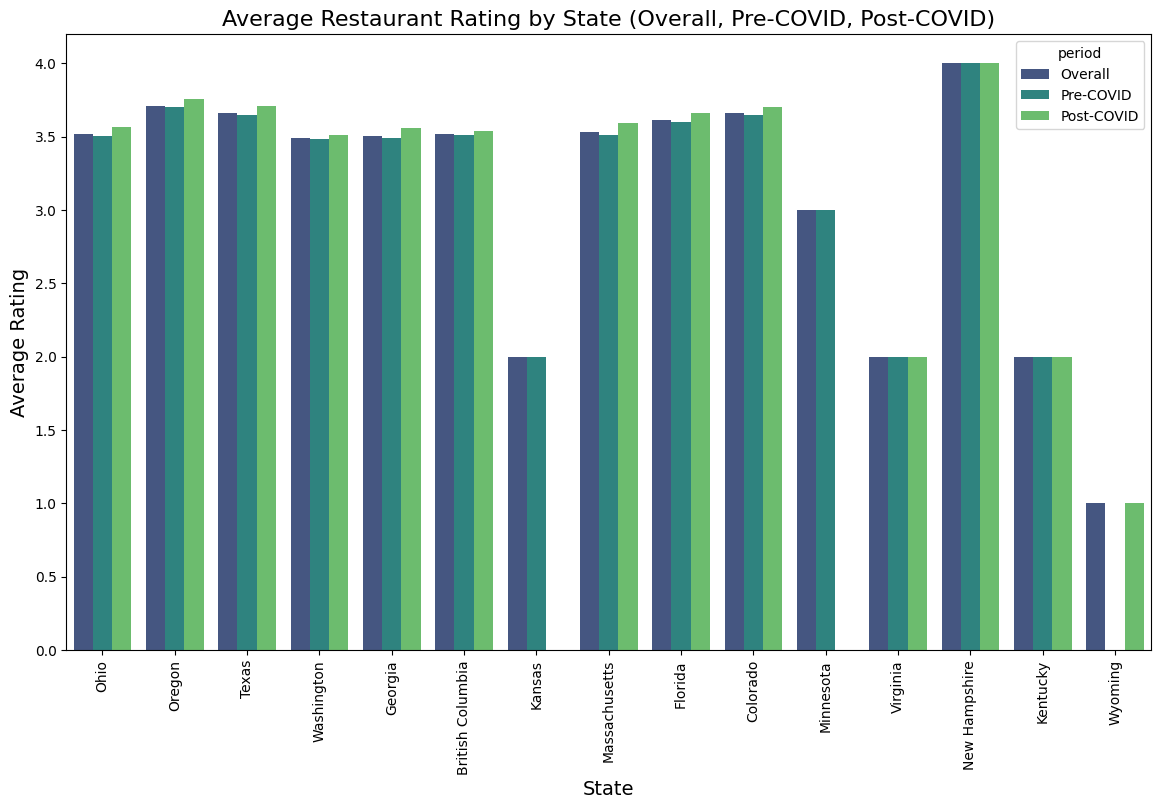

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine the dataframes into one with an additional 'period' column
combined_df = pd.concat([avg_rating_overall, avg_rating_pre, avg_rating_post])

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a seaborn bar plot
sns.barplot(data=combined_df, x='state_', y='avg_stars', hue='period', palette='viridis')

# Add titles and labels
plt.title('Average Restaurant Rating by State (Overall, Pre-COVID, Post-COVID)', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=90)  # Rotate x labels for better readability

# Display the plot
plt.show()

In [38]:
from pyspark.sql.functions import lit

def avg_rating_by_state(df, period):
    avg_rating = df.groupBy("state_").agg(avg("stars").alias("avg_stars")).withColumn("period", lit(period))
    return avg_rating

# Calculate average ratings for each period
avg_rating_overall = avg_rating_by_state(df, 'Overall')
avg_rating_pre = avg_rating_by_state(df.filter(col("period") == "Pre-COVID"), 'Pre-COVID')
avg_rating_post = avg_rating_by_state(df.filter(col("period") == "Post-COVID"), 'Post-COVID')

# Convert to Pandas DataFrames
avg_rating_overall_pd = avg_rating_overall.toPandas()
avg_rating_pre_pd = avg_rating_pre.toPandas()
avg_rating_post_pd = avg_rating_post.toPandas()

# Add a column for period to distinguish between different analyses
avg_rating_overall_pd['period'] = 'Overall'
avg_rating_pre_pd['period'] = 'Pre-COVID'
avg_rating_post_pd['period'] = 'Post-COVID'

# Combine the DataFrames
combined_avg_rating = pd.concat([avg_rating_overall_pd, avg_rating_pre_pd, avg_rating_post_pd], ignore_index=True)

# Save to CSV
combined_avg_rating.to_csv('avg_rating_by_state_combined.csv', index=False)



24/09/14 05:16:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:16:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:16:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:16:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:16:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:16:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:16:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:16:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:16:48 WARN RowBasedKeyValueBatch: Calling spill() on

**Distribution of Reviews (Overall, Pre-COVID, Post-COVID)**

In [51]:
def review_distribution(df, period):
    distribution = df.groupBy("review_count").count().withColumn("period", lit(period))
    return distribution

# Overall Distribution
dist_overall = review_distribution(df, 'Overall').toPandas()

# Pre-COVID Distribution
dist_pre = review_distribution(df.filter(col("period") == "Pre-COVID"), 'Pre-COVID').toPandas()

# Post-COVID Distribution
dist_post = review_distribution(df.filter(col("period") == "Post-COVID"), 'Post-COVID').toPandas()


24/09/14 02:32:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 02:32:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 02:32:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 02:32:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 02:32:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 02:32:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 02:32:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 02:32:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 02:32:51 WARN RowBasedKeyValueBatch: Calling spill() on

**Trend Analysis of Ratings Over Time (Overall, Pre-COVID, Post-COVID)**

In [50]:
def trend_analysis(df, period):
    trend = df.groupBy("date_").agg(avg("stars").alias("avg_stars")).withColumn("period", lit(period)).orderBy("date_")
    return trend

# Overall Trend
trend_overall = trend_analysis(df, 'Overall').toPandas()

# Pre-COVID Trend
trend_pre = trend_analysis(df.filter(col("period") == "Pre-COVID"), 'Pre-COVID').toPandas()

# Post-COVID Trend
trend_post = trend_analysis(df.filter(col("period") == "Post-COVID"), 'Post-COVID').toPandas()


24/09/14 06:20:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:20:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:20:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:20:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:20:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:20:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:20:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:20:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 06:20:18 WARN RowBasedKeyValueBatch: Calling spill() on

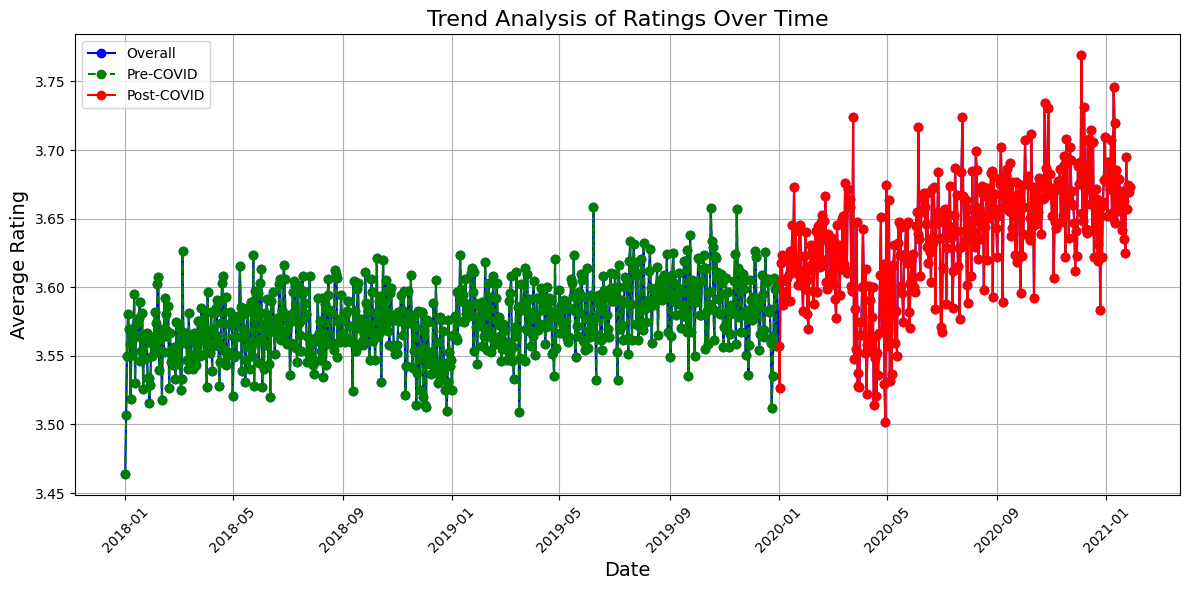

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot Overall Trend
plt.plot(trend_overall['date_'], trend_overall['avg_stars'], label='Overall', color='blue', linestyle='-', marker='o')

# Plot Pre-COVID Trend
plt.plot(trend_pre['date_'], trend_pre['avg_stars'], label='Pre-COVID', color='green', linestyle='--', marker='o')

# Plot Post-COVID Trend
plt.plot(trend_post['date_'], trend_post['avg_stars'], label='Post-COVID', color='red', linestyle='-', marker='o')

# Add titles and labels
plt.title('Trend Analysis of Ratings Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

**Average Metrics (Useful, Funny, Cool) by State (Overall, Pre-COVID, Post-COVID)**

In [39]:
def avg_metrics_by_type(df, period):
    avg_metrics = df.groupBy("state_").agg(
        avg("useful").alias("avg_useful"),
        avg("funny").alias("avg_funny"),
        avg("cool").alias("avg_cool")
    ).withColumn("period", lit(period))
    return avg_metrics

# Overall Average Metrics by Type
avg_metrics_overall = avg_metrics_by_type(df, 'Overall').toPandas()

# Pre-COVID Average Metrics by Type
avg_metrics_pre = avg_metrics_by_type(df.filter(col("period") == "Pre-COVID"), 'Pre-COVID').toPandas()

# Post-COVID Average Metrics by Type
avg_metrics_post = avg_metrics_by_type(df.filter(col("period") == "Post-COVID"), 'Post-COVID').toPandas()


24/09/14 05:32:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:32:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:32:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:32:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:32:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:32:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:32:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:32:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 05:32:22 WARN RowBasedKeyValueBatch: Calling spill() on

In [41]:
import pandas as pd

# Combine the DataFrames
combined_avg_metrics = pd.concat([avg_metrics_overall, avg_metrics_pre, avg_metrics_post], ignore_index=True)


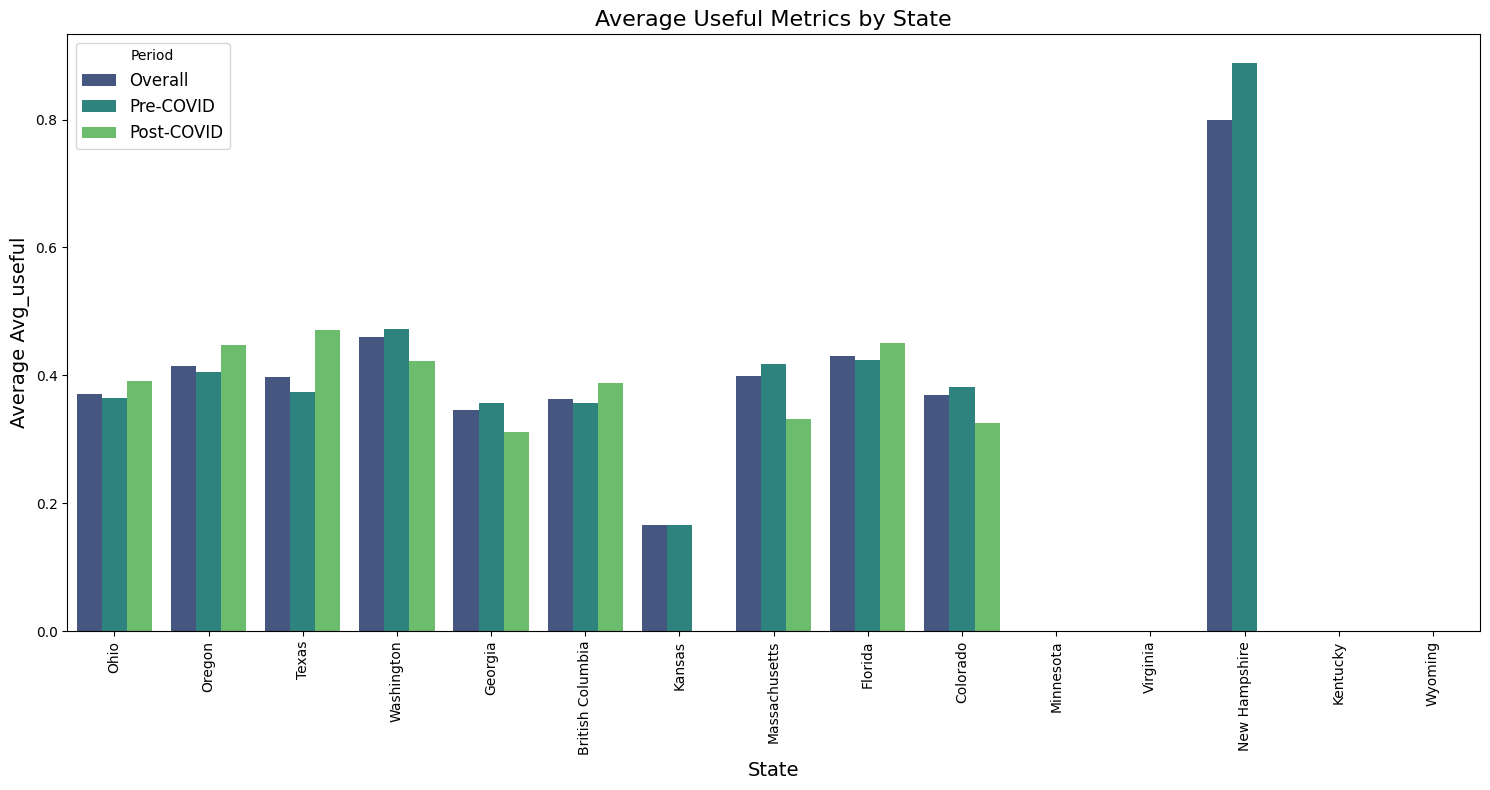

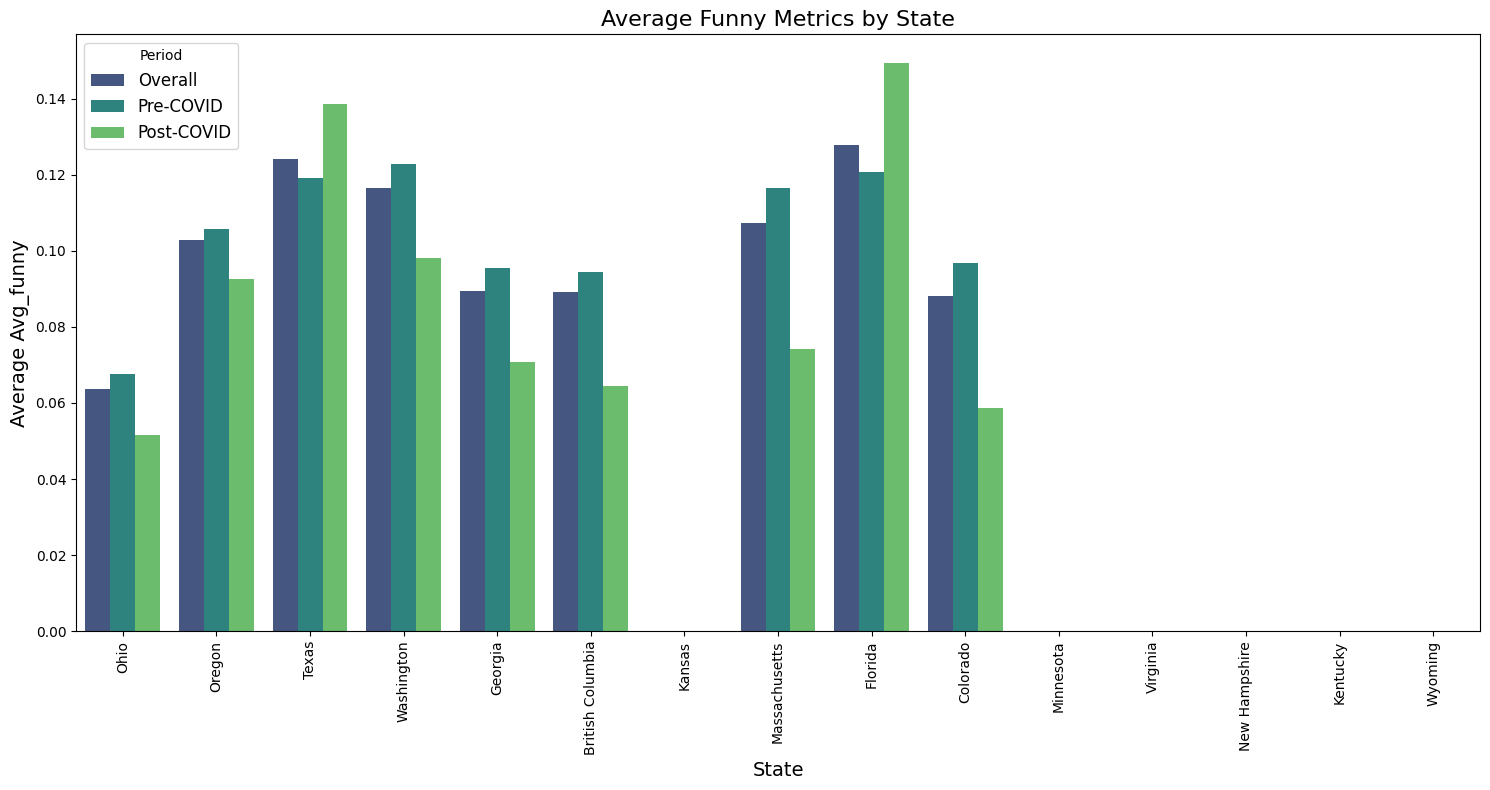

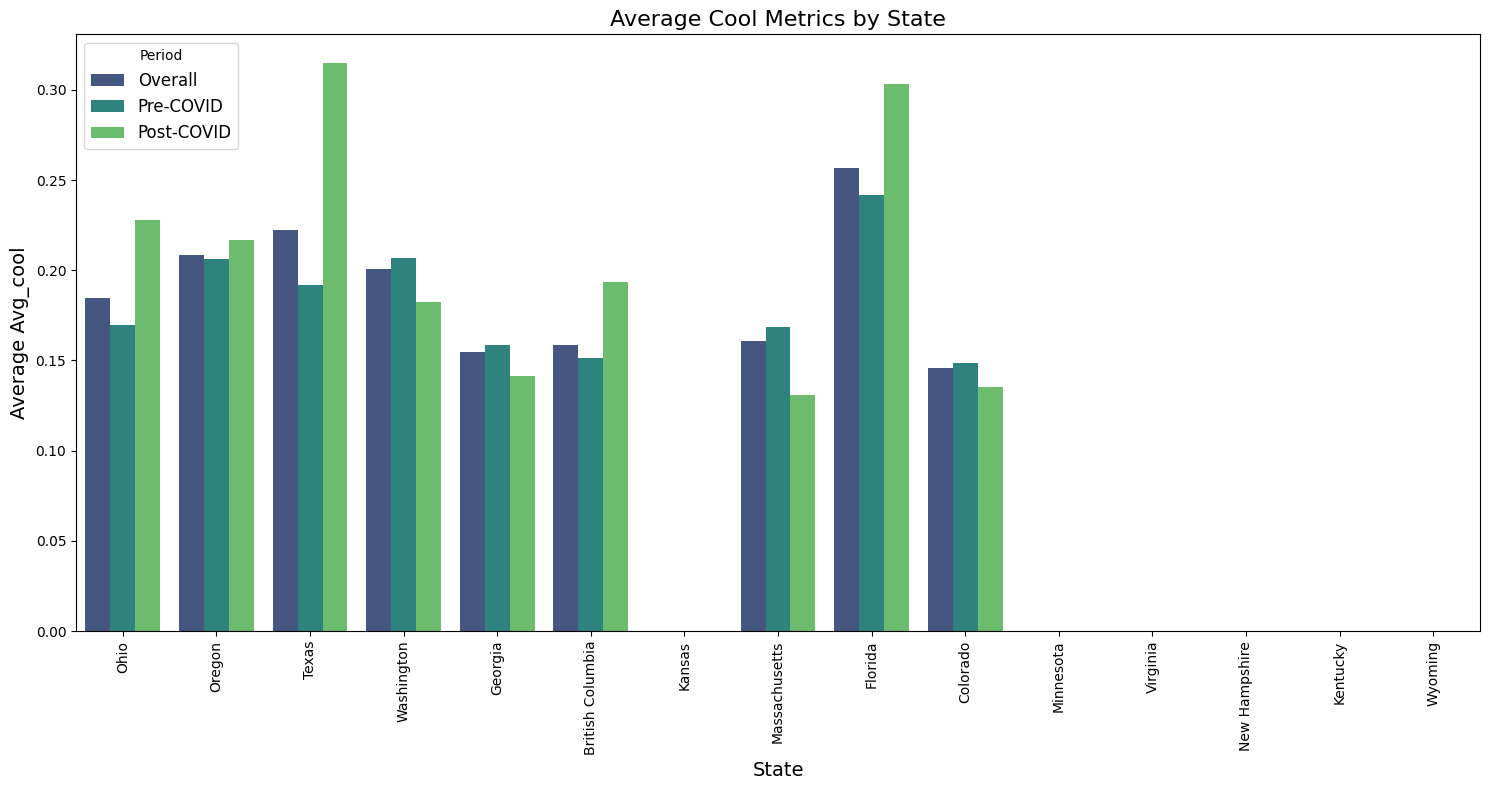

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to plot metrics
def plot_avg_metrics(df, metric, title):
    plt.figure(figsize=(15, 8))
    sns.barplot(x='state_', y=metric, hue='period', data=df, palette='viridis')
    plt.xticks(rotation=90)
    plt.title(title, fontsize=16)
    plt.xlabel('State', fontsize=14)
    plt.ylabel('Average ' + metric.capitalize(), fontsize=14)
    plt.legend(title='Period', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot average metrics
plot_avg_metrics(combined_avg_metrics, 'avg_useful', 'Average Useful Metrics by State')
plot_avg_metrics(combined_avg_metrics, 'avg_funny', 'Average Funny Metrics by State')
plot_avg_metrics(combined_avg_metrics, 'avg_cool', 'Average Cool Metrics by State')


**Percentage of Ratings across Restaurants**

In [58]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Overall Analysis
stars_wise_overall = df.groupBy('stars').count().orderBy(col('stars').desc())
stars_wise_overall_pd = stars_wise_overall.toPandas()

# Extract data for plotting
star_overall = stars_wise_overall_pd['stars'].tolist()
count_overall = stars_wise_overall_pd['count'].tolist()

# Pre-COVID Analysis
stars_wise_pre = df_pre.groupBy('stars').count().orderBy(col('stars').desc())
stars_wise_pre_pd = stars_wise_pre.toPandas()

# Extract data for plotting
star_pre = stars_wise_pre_pd['stars'].tolist()
count_pre = stars_wise_pre_pd['count'].tolist()

# Post-COVID Analysis
stars_wise_post = df_post.groupBy('stars').count().orderBy(col('stars').desc())
stars_wise_post_pd = stars_wise_post.toPandas()

# Extract data for plotting
star_post = stars_wise_post_pd['stars'].tolist()
count_post = stars_wise_post_pd['count'].tolist()




24/09/14 07:36:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 07:36:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 07:36:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 07:36:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 07:36:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 07:36:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 07:36:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 07:36:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 07:36:59 WARN RowBasedKeyValueBatch: Calling spill() on

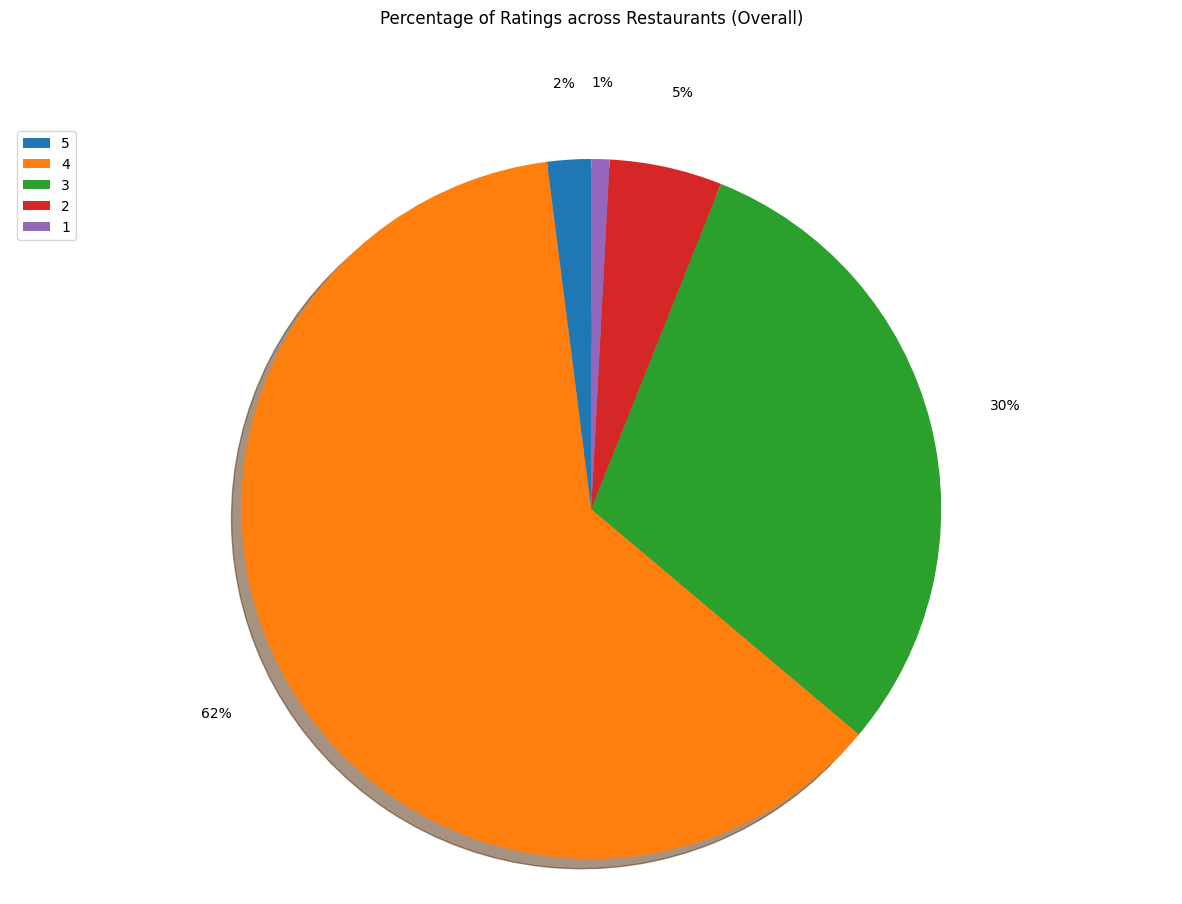

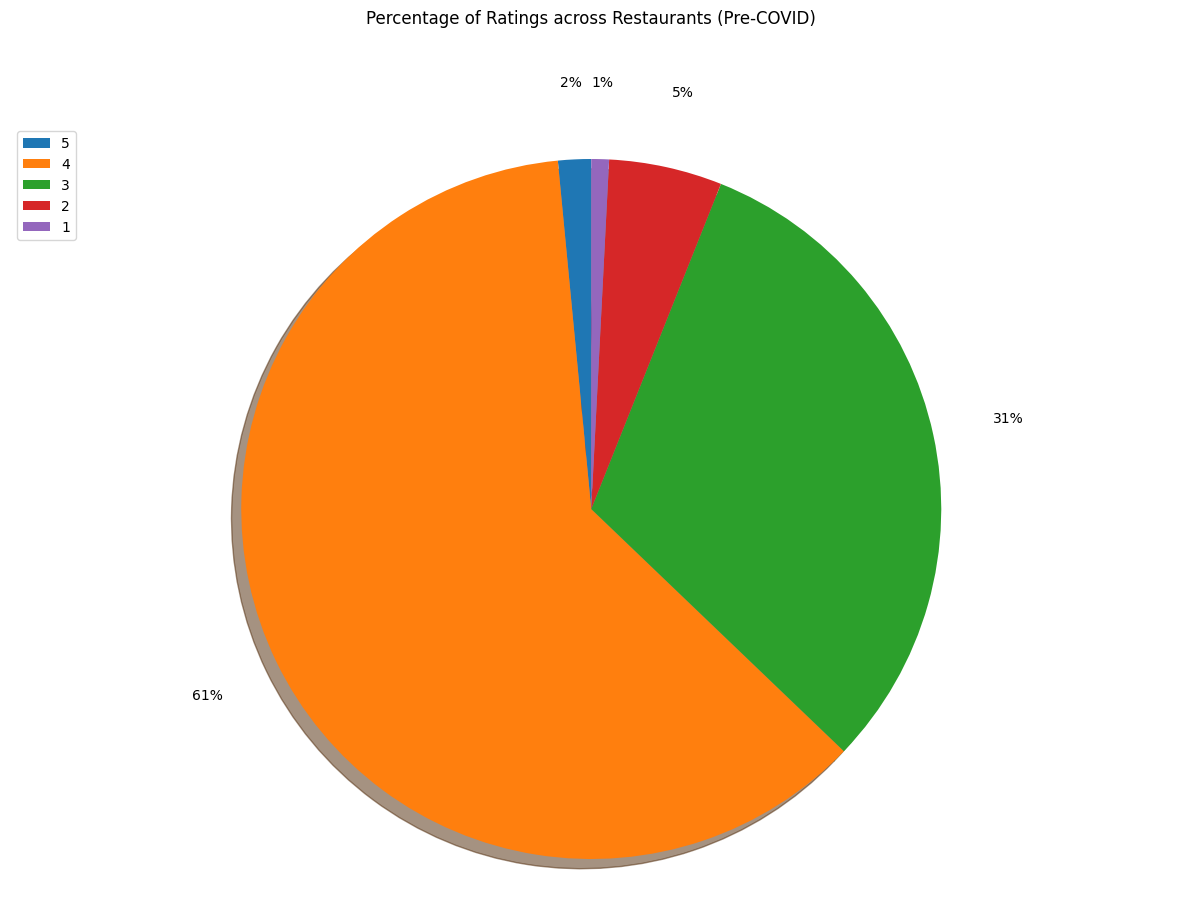

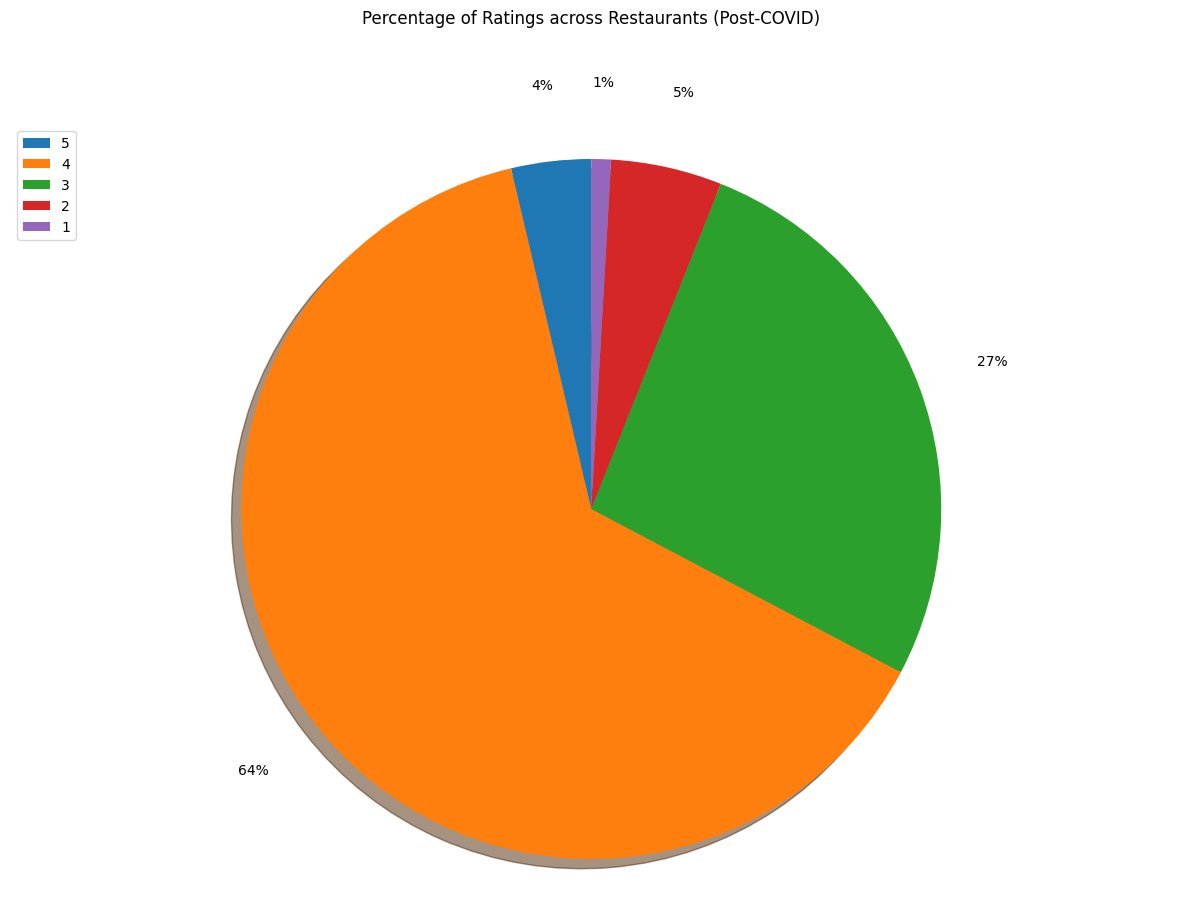

In [63]:
# Plot for Overall
plt.figure(figsize=(15, 10))
plt.pie(
    count_overall, 
    labels=None, 
    autopct='%1.f%%', 
    startangle=90, 
    shadow=True, 
    pctdistance=1.22
)
plt.title('Percentage of Ratings across Restaurants (Overall)', y=1.12)
plt.axis('equal')
plt.legend(labels=star_overall, loc='upper left')
plt.show()

# Plot for Pre-COVID
plt.figure(figsize=(15, 10))
plt.pie(
    count_pre, 
    labels=None, 
    autopct='%1.f%%', 
    startangle=90, 
    shadow=True, 
    pctdistance=1.22
)
plt.title('Percentage of Ratings across Restaurants (Pre-COVID)', y=1.12)
plt.axis('equal')
plt.legend(labels=star_pre, loc='upper left')
plt.show()

# Plot for Post-COVID
plt.figure(figsize=(15, 10))
plt.pie(
    count_post, 
    labels=None, 
    autopct='%1.f%%', 
    startangle=90, 
    shadow=True, 
    pctdistance=1.22
)
plt.title('Percentage of Ratings across Restaurants (Post-COVID)', y=1.12)
plt.axis('equal')
plt.legend(labels=star_post, loc='upper left')
plt.show()



In [61]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date

stars_wise_overall_pd['period'] = 'Overall'
stars_wise_pre_pd['period'] = 'Pre-COVID'
stars_wise_post_pd['period'] = 'Post-COVID'

# Combine all dataframes
combined_df = pd.concat([stars_wise_overall_pd, stars_wise_pre_pd, stars_wise_post_pd])

# Save combined dataframe to CSV
combined_df.to_csv('combined_analysis.csv', index=False)



CSV file with combined analysis has been created successfully.


In [67]:
from pyspark.sql.functions import col, lit, avg
import pandas as pd

# Function to calculate average metrics by city and period
def avg_metrics_by_city(df, period):
    avg_metrics = df.groupBy("city").agg(
        avg("useful").alias("avg_useful"),
        avg("funny").alias("avg_funny"),
        avg("cool").alias("avg_cool")
    ).withColumn("period", lit(period))
    return avg_metrics

# Overall Average Metrics by City
avg_metrics_overall = avg_metrics_by_city(df, 'Overall').toPandas()

# Pre-COVID Average Metrics by City
avg_metrics_pre = avg_metrics_by_city(df.filter(col("period") == "Pre-COVID"), 'Pre-COVID').toPandas()

# Post-COVID Average Metrics by City
avg_metrics_post = avg_metrics_by_city(df.filter(col("period") == "Post-COVID"), 'Post-COVID').toPandas()

# Combine all results into a single DataFrame
combined_avg_metrics = pd.concat([avg_metrics_overall, avg_metrics_pre, avg_metrics_post])


 

24/09/14 09:29:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 09:29:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 09:29:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 09:29:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 09:29:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 09:29:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 09:29:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 09:29:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 09:29:56 WARN RowBasedKeyValueBatch: Calling spill() on

**Top 10 cities**

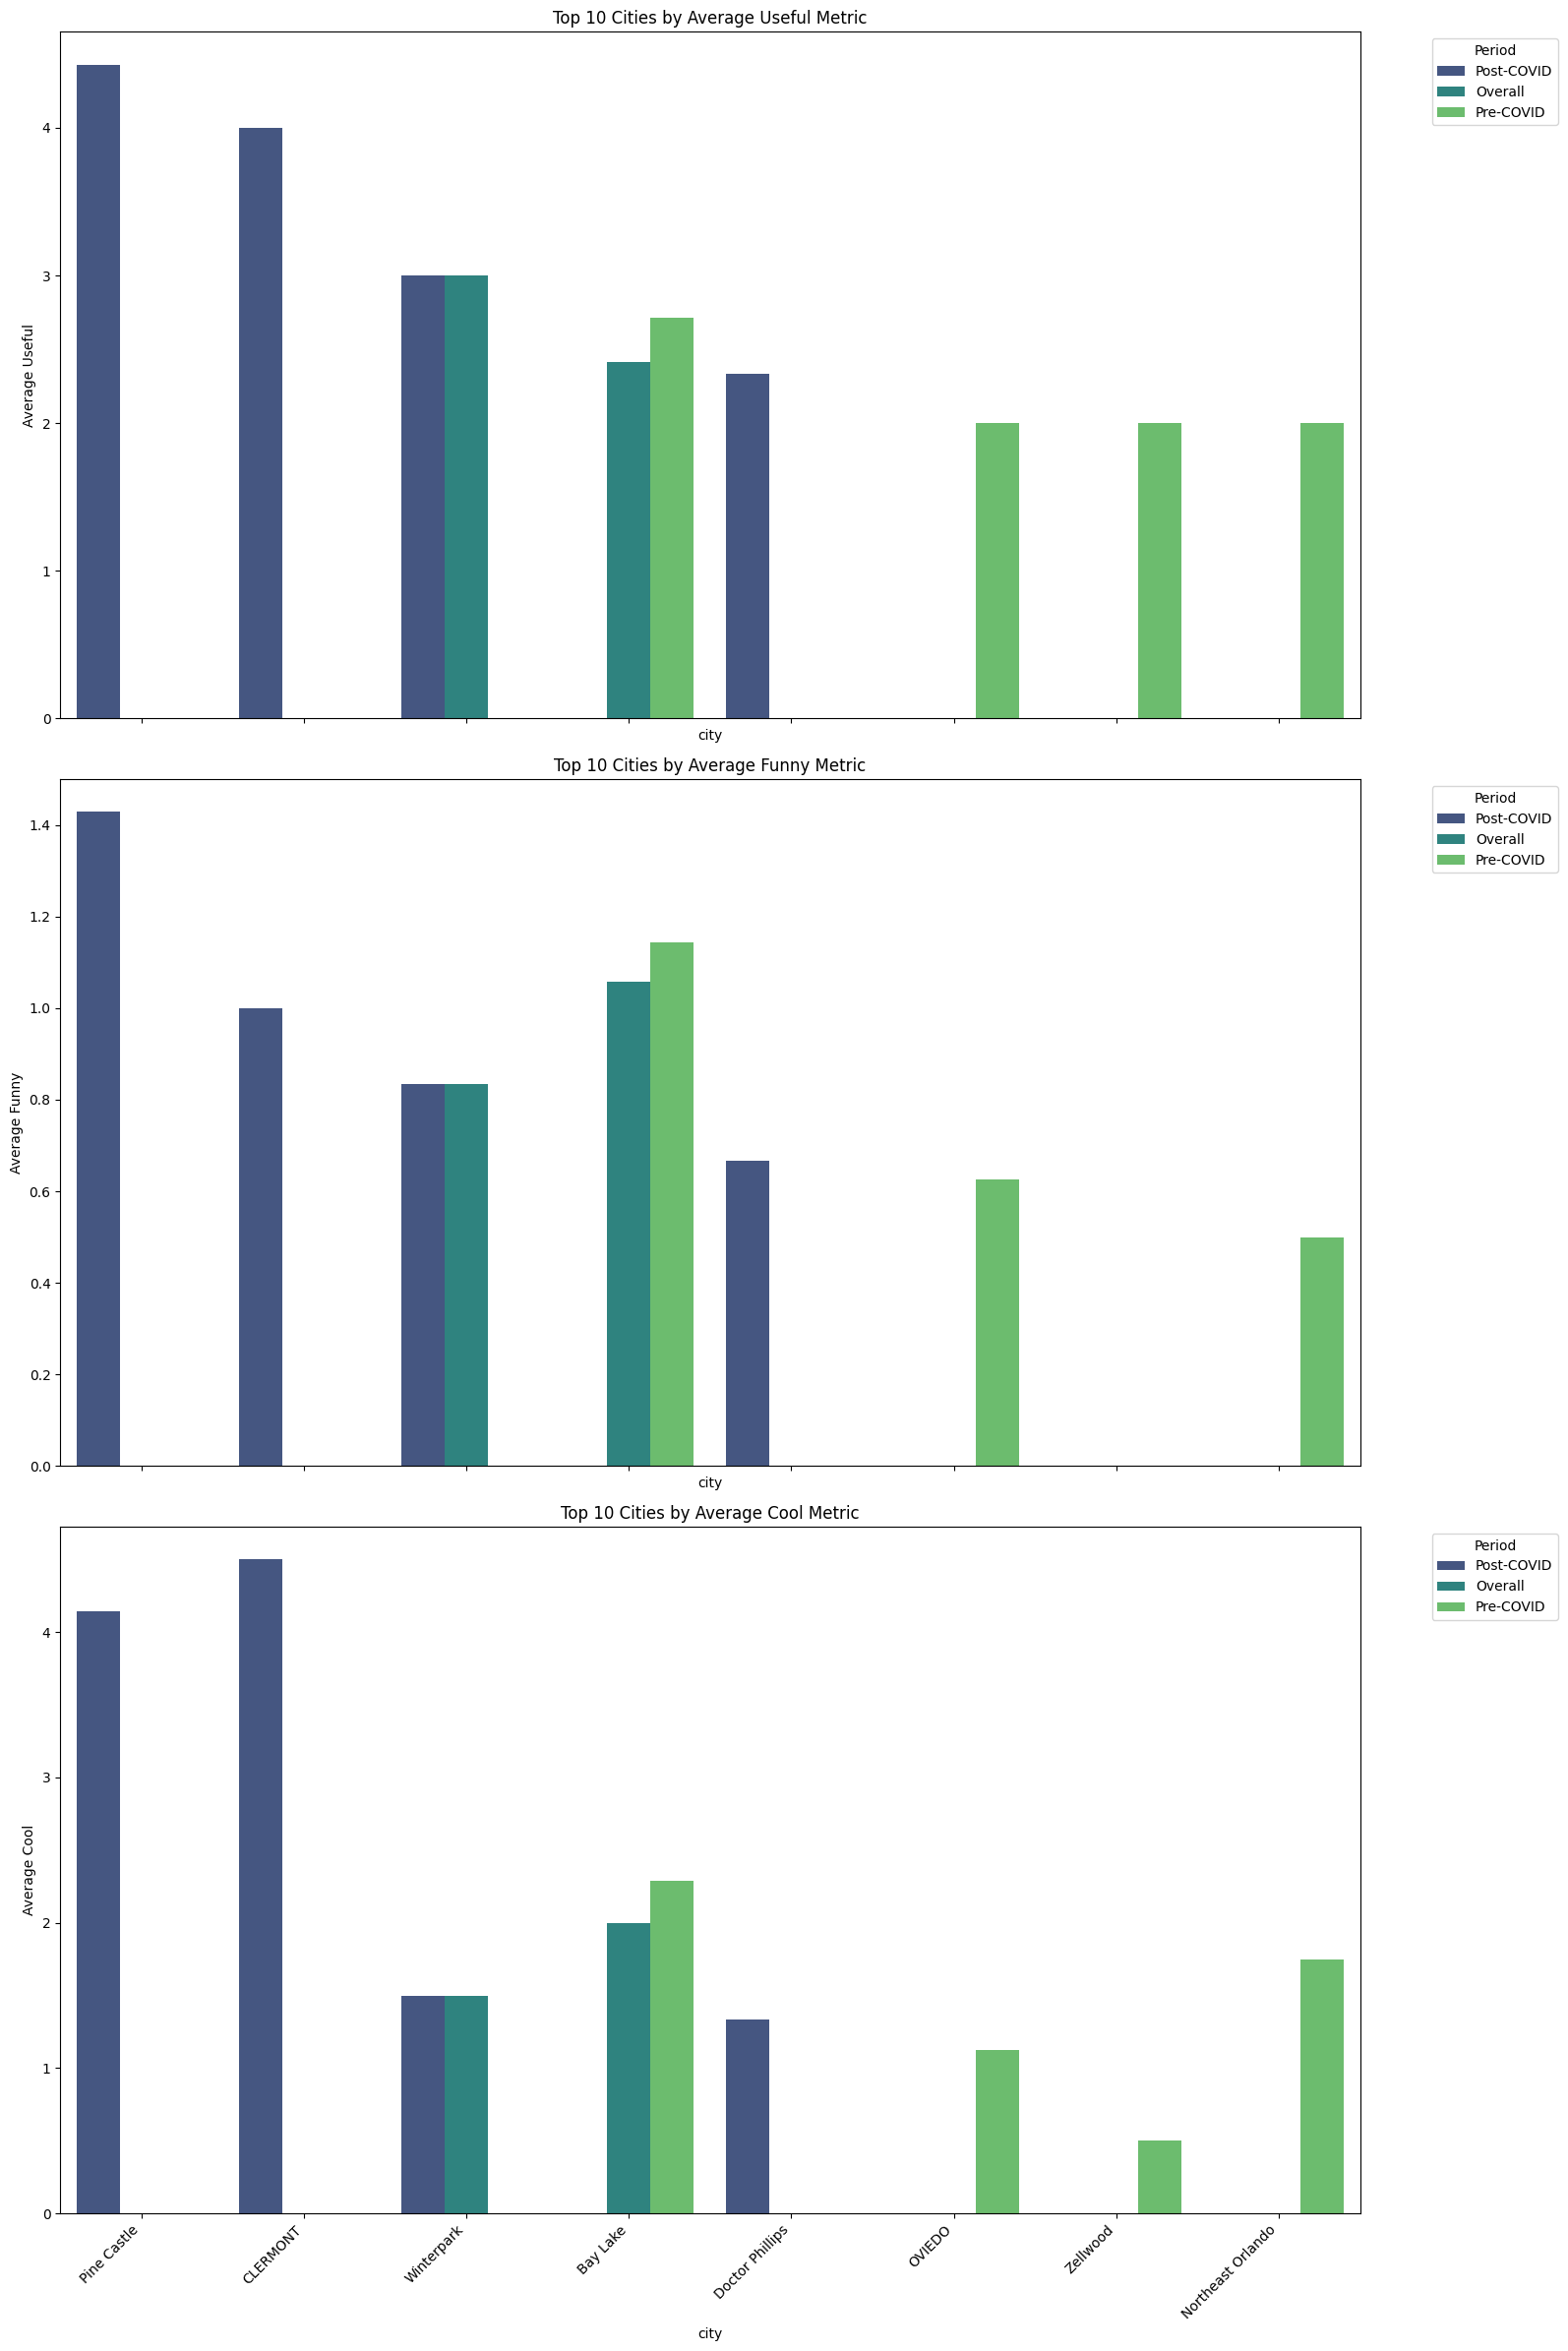

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get top 10 cities by avg_useful
def get_top_10_cities(df):
    return df.sort_values(by='avg_useful', ascending=False).head(10)

# Filter the combined data for top 10 cities using avg_useful
top_10_cities = get_top_10_cities(combined_avg_metrics)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(16, 24), sharex=True)

# Plot for avg_useful
sns.barplot(x='city', y='avg_useful', hue='period', data=top_10_cities, palette='viridis', ax=axs[0])
axs[0].set_title('Top 10 Cities by Average Useful Metric')
axs[0].set_ylabel('Average Useful')
axs[0].legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for avg_funny
sns.barplot(x='city', y='avg_funny', hue='period', data=top_10_cities, palette='viridis', ax=axs[1])
axs[1].set_title('Top 10 Cities by Average Funny Metric')
axs[1].set_ylabel('Average Funny')
axs[1].legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for avg_cool
sns.barplot(x='city', y='avg_cool', hue='period', data=top_10_cities, palette='viridis', ax=axs[2])
axs[2].set_title('Top 10 Cities by Average Cool Metric')
axs[2].set_ylabel('Average Cool')
axs[2].legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout and show plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [78]:
import pandas as pd

# Function to get top 10 cities by avg_useful
def get_top_10_cities(df, metric):
    return df.sort_values(by=metric, ascending=False).head(10)

# Get top 10 cities for each metric
top_10_useful = get_top_10_cities(combined_avg_metrics, 'avg_useful')
top_10_funny = get_top_10_cities(combined_avg_metrics, 'avg_funny')
top_10_cool = get_top_10_cities(combined_avg_metrics, 'avg_cool')

# Combine the data into a single DataFrame
# To keep it clear, include a column to identify the metric
top_10_useful['metric'] = 'avg_useful'
top_10_funny['metric'] = 'avg_funny'
top_10_cool['metric'] = 'avg_cool'

# Concatenate the DataFrames
combined_top_10 = pd.concat([top_10_useful, top_10_funny, top_10_cool], ignore_index=True)

# Save to CSV
combined_top_10.to_csv('top_10_cities_metrics.csv', index=False)

print("CSV file 'top_10_cities_metrics.csv' has been created successfully.")



CSV file 'top_10_cities_metrics.csv' has been created successfully.


**Top 20 Restuarnts** 

In [87]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame
def get_top_20_restaurants(df, period=None):
    if period:
        df_period = df.filter(df['period'] == period)
    else:
        df_period = df  # If no period is provided, use the entire dataframe
    
    top_20 = (df_period
              .groupBy('name')
              .count()
              .orderBy(F.desc('count'))
              .limit(20)
              .toPandas())
    
    top_20.columns = ['name', 'count']
    return top_20

# Extract top 20 restaurants for each period
top_20_overall = get_top_20_restaurants(df)  # No period means overall
top_20_pre = get_top_20_restaurants(df, 'Pre-COVID')
top_20_post = get_top_20_restaurants(df, 'Post-COVID')

# Check if the DataFrames are not empty
print("Top 20 Overall:")
print(top_20_overall.head())
print("Top 20 Pre-COVID:")
print(top_20_pre.head())
print("Top 20 Post-COVID:")
print(top_20_post.head())



24/09/14 10:37:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:37:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:37:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:37:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:37:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:37:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:37:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:37:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:37:04 WARN RowBasedKeyValueBatch: Calling spill() on

Top 20 Overall:
                     name  count
0              McDonald's   5604
1  Chipotle Mexican Grill   3250
2             Chick-fil-A   3062
3               Taco Bell   2458
4            Panera Bread   2378
Top 20 Pre-COVID:
                     name  count
0              McDonald's   4341
1             Chick-fil-A   2275
2  Chipotle Mexican Grill   2042
3            Panera Bread   1866
4               Taco Bell   1789
Top 20 Post-COVID:
                        name  count
0                 McDonald's   1263
1     Chipotle Mexican Grill   1208
2                Chick-fil-A    787
3  Popeyes Louisiana Kitchen    717
4                  Taco Bell    669


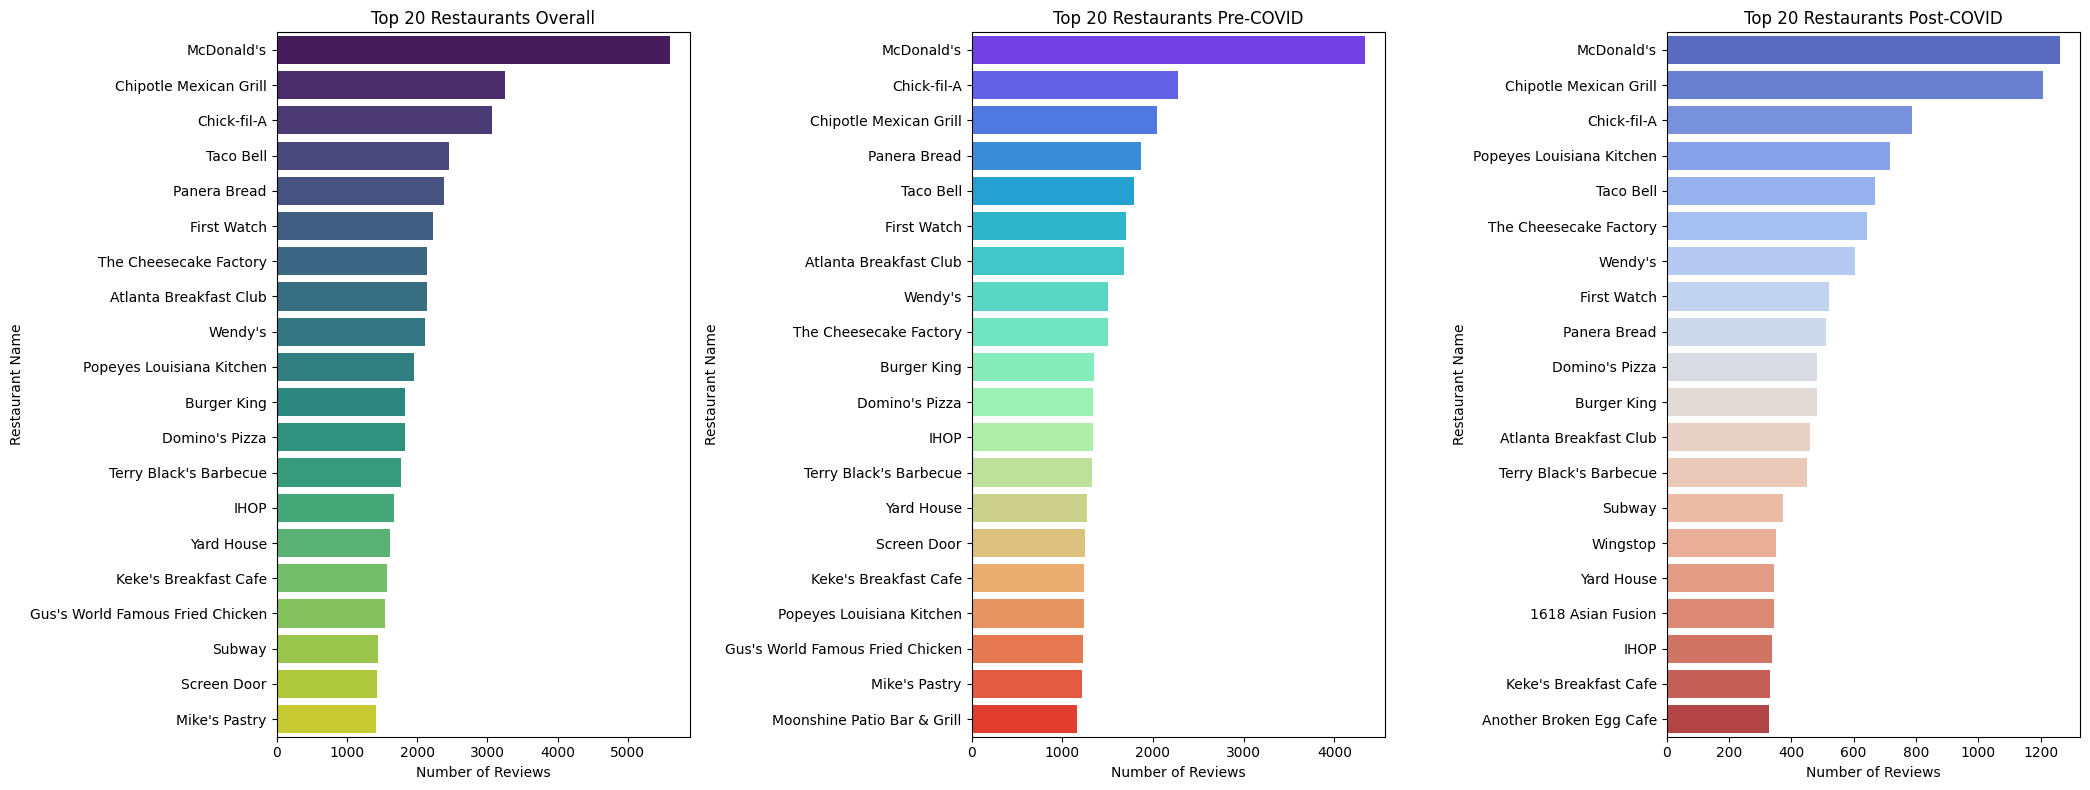

In [88]:
# Plotting
fig, ax = plt.subplots(1, 3, figsize=(21, 8))

# Plot for overall
sns.barplot(x='count', y='name', data=top_20_overall, palette='viridis', ax=ax[0])
ax[0].set_title('Top 20 Restaurants Overall')
ax[0].set_xlabel('Number of Reviews')
ax[0].set_ylabel('Restaurant Name')

# Plot for pre-COVID
sns.barplot(x='count', y='name', data=top_20_pre, palette='rainbow', ax=ax[1])
ax[1].set_title('Top 20 Restaurants Pre-COVID')
ax[1].set_xlabel('Number of Reviews')
ax[1].set_ylabel('Restaurant Name')

# Plot for post-COVID
sns.barplot(x='count', y='name', data=top_20_post, palette='coolwarm', ax=ax[2])
ax[2].set_title('Top 20 Restaurants Post-COVID')
ax[2].set_xlabel('Number of Reviews')
ax[2].set_ylabel('Restaurant Name')

plt.tight_layout()
plt.show()


In [94]:
import pandas as pd

# Add a 'period' column to each DataFrame
top_20_overall['period'] = 'Overall'
top_20_pre['period'] = 'Pre-COVID'
top_20_post['period'] = 'Post-COVID'

# Combine the DataFrames
combined_top_20 = pd.concat([top_20_overall, top_20_pre, top_20_post])

# Save the combined data to a CSV file
combined_top_20.to_csv('top_20_restaurants.csv', index=False)


**Average Metrics (Useful, Funny, Cool) by Restuarents (Overall, Pre-COVID, Post-COVID)**

In [90]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate top 20 restaurants for a given period
def get_top_20_restaurants(df, period=None):
    if period:
        df_period = df.filter(df['period'] == period)
    else:
        df_period = df  # If no period is provided, use the entire dataframe
    
    top_20 = (df_period
              .groupBy('name')
              .count()
              .orderBy(F.desc('count'))
              .limit(20)
              .toPandas())
    
    top_20.columns = ['name', 'count']
    return top_20

# Function to calculate average metrics for a list of restaurants
def get_avg_metrics(df, restaurant_names, period=None):
    if period:
        df_period = df.filter(df['period'] == period)
    else:
        df_period = df  # If no period is provided, use the entire dataframe
    
    avg_metrics = (df_period
                   .filter(df['name'].isin(restaurant_names))  # Filter for top 20 restaurants
                   .groupBy('name')
                   .agg(F.avg('useful').alias('avg_useful'),
                        F.avg('funny').alias('avg_funny'),
                        F.avg('cool').alias('avg_cool'))
                   .toPandas())
    return avg_metrics


In [91]:
# Extract top 20 restaurants for each period
top_20_overall = get_top_20_restaurants(df)  # No period means overall
top_20_pre = get_top_20_restaurants(df, 'Pre-COVID')
top_20_post = get_top_20_restaurants(df, 'Post-COVID')

# Get restaurant names for each period
overall_restaurants = top_20_overall['name'].tolist()
pre_restaurants = top_20_pre['name'].tolist()
post_restaurants = top_20_post['name'].tolist()

# Calculate average metrics for the top 20 restaurants in each period
avg_metrics_overall = get_avg_metrics(df, overall_restaurants)
avg_metrics_pre = get_avg_metrics(df, pre_restaurants, 'Pre-COVID')
avg_metrics_post = get_avg_metrics(df, post_restaurants, 'Post-COVID')

24/09/14 10:58:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:58:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:58:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:58:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:58:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:58:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:58:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:58:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 10:58:22 WARN RowBasedKeyValueBatch: Calling spill() on

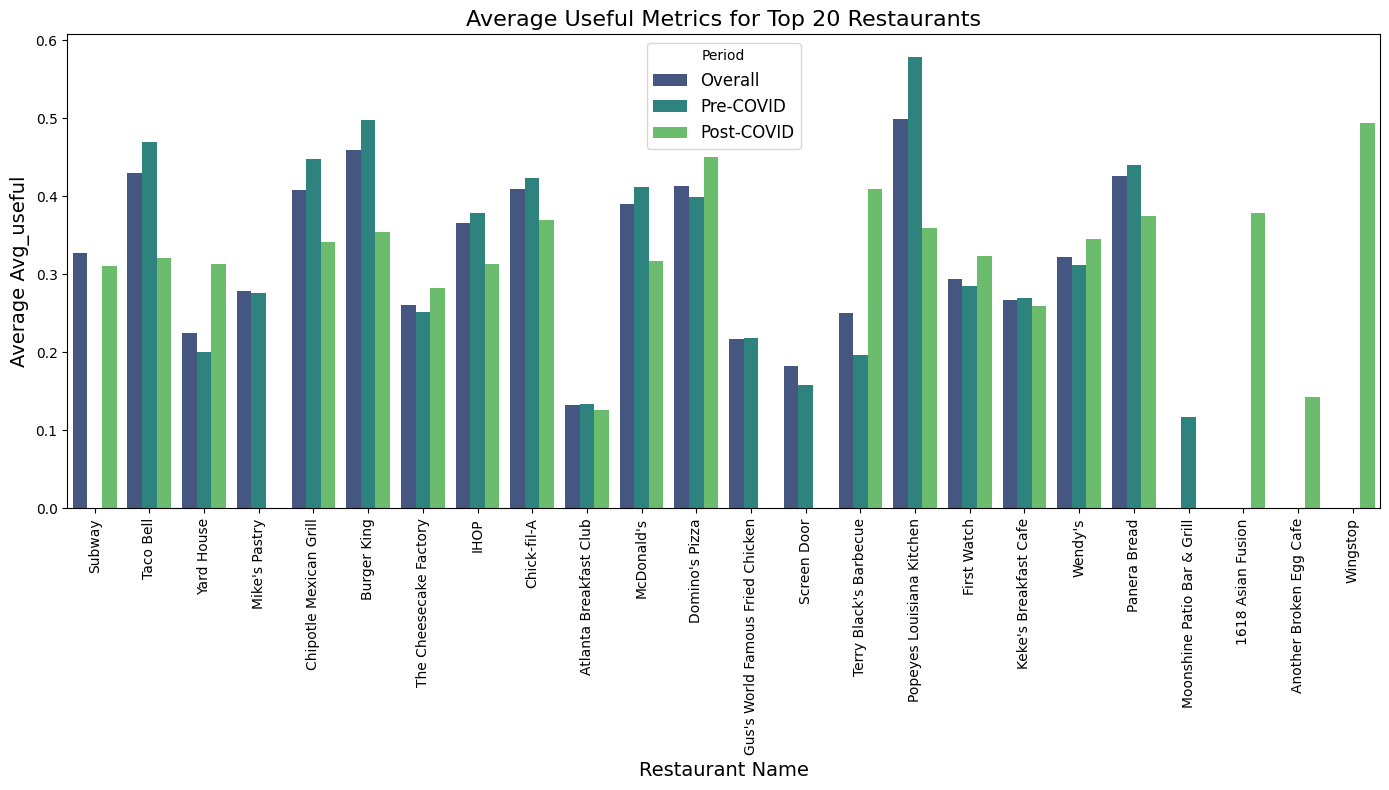

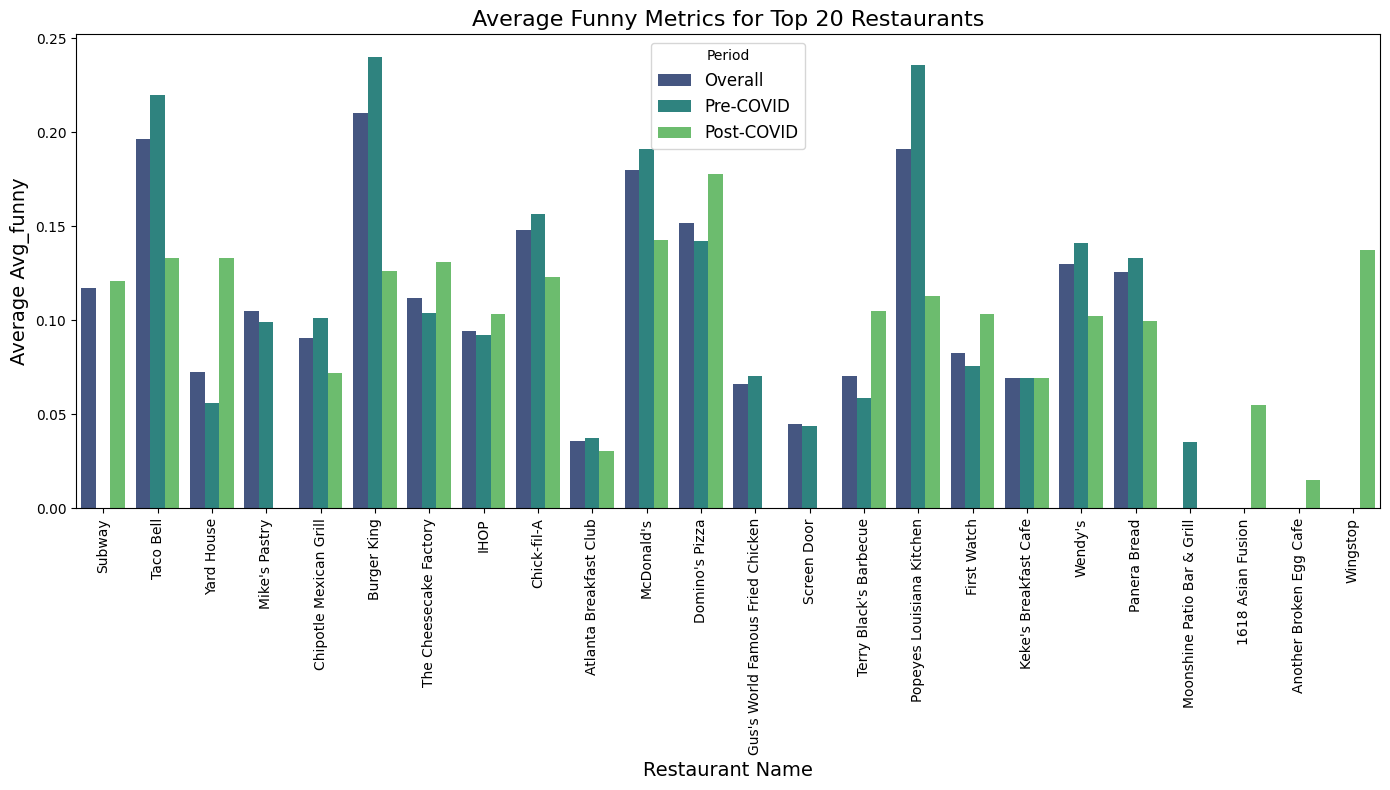

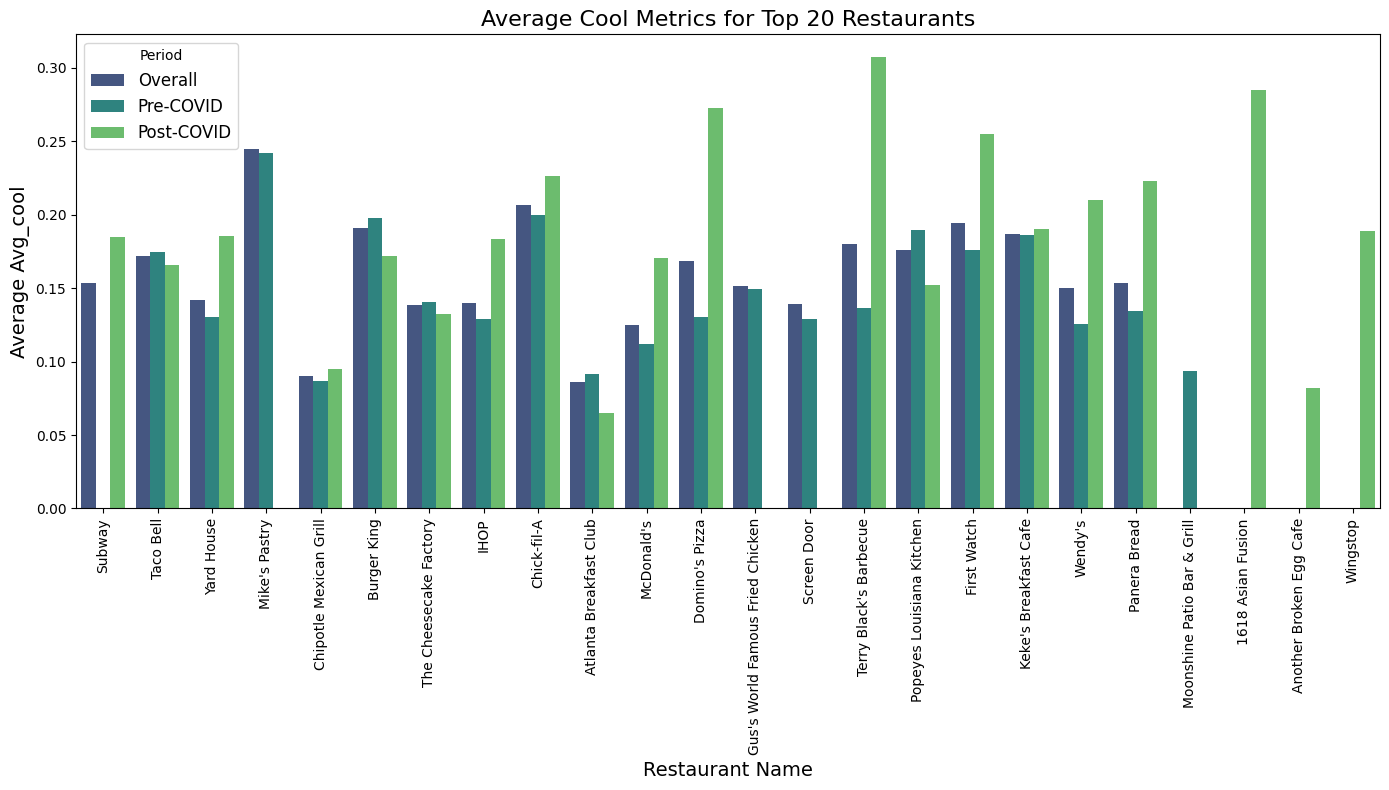

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot average metrics
def plot_avg_metrics(avg_metrics_overall, avg_metrics_pre, avg_metrics_post, metric, title):
    plt.figure(figsize=(14, 8))
    
    # Merge data from all periods
    combined_data = pd.concat([
        avg_metrics_overall[['name', metric]].assign(period='Overall'),
        avg_metrics_pre[['name', metric]].assign(period='Pre-COVID'),
        avg_metrics_post[['name', metric]].assign(period='Post-COVID')
    ])

    # Plot grouped bar chart
    sns.barplot(x='name', y=metric, hue='period', data=combined_data, palette='viridis')

    plt.xticks(rotation=90)
    plt.title(title, fontsize=16)
    plt.xlabel('Restaurant Name', fontsize=14)
    plt.ylabel(f'Average {metric.capitalize()}', fontsize=14)
    plt.legend(title='Period', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot average metrics for Useful, Funny, and Cool
plot_avg_metrics(avg_metrics_overall, avg_metrics_pre, avg_metrics_post, 'avg_useful', 'Average Useful Metrics for Top 20 Restaurants')
plot_avg_metrics(avg_metrics_overall, avg_metrics_pre, avg_metrics_post, 'avg_funny', 'Average Funny Metrics for Top 20 Restaurants')
plot_avg_metrics(avg_metrics_overall, avg_metrics_pre, avg_metrics_post, 'avg_cool', 'Average Cool Metrics for Top 20 Restaurants')


In [93]:
# Combine the top 20 data for each period and metric
combined_data = pd.concat([
    avg_metrics_overall[['name', 'avg_useful', 'avg_funny', 'avg_cool']].assign(period='Overall'),
    avg_metrics_pre[['name', 'avg_useful', 'avg_funny', 'avg_cool']].assign(period='Pre-COVID'),
    avg_metrics_post[['name', 'avg_useful', 'avg_funny', 'avg_cool']].assign(period='Post-COVID')
])

# Save the combined data to CSV
combined_data.to_csv('top_20_restaurants_avg_metrics.csv', index=False)


CSV file has been saved.


**Sentiment Analysis for Resturents**

24/09/14 11:34:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 11:34:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 11:34:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 11:34:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 11:34:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 11:34:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 11:34:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 11:34:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/14 11:34:04 WARN RowBasedKeyValueBatch: Calling spill() on

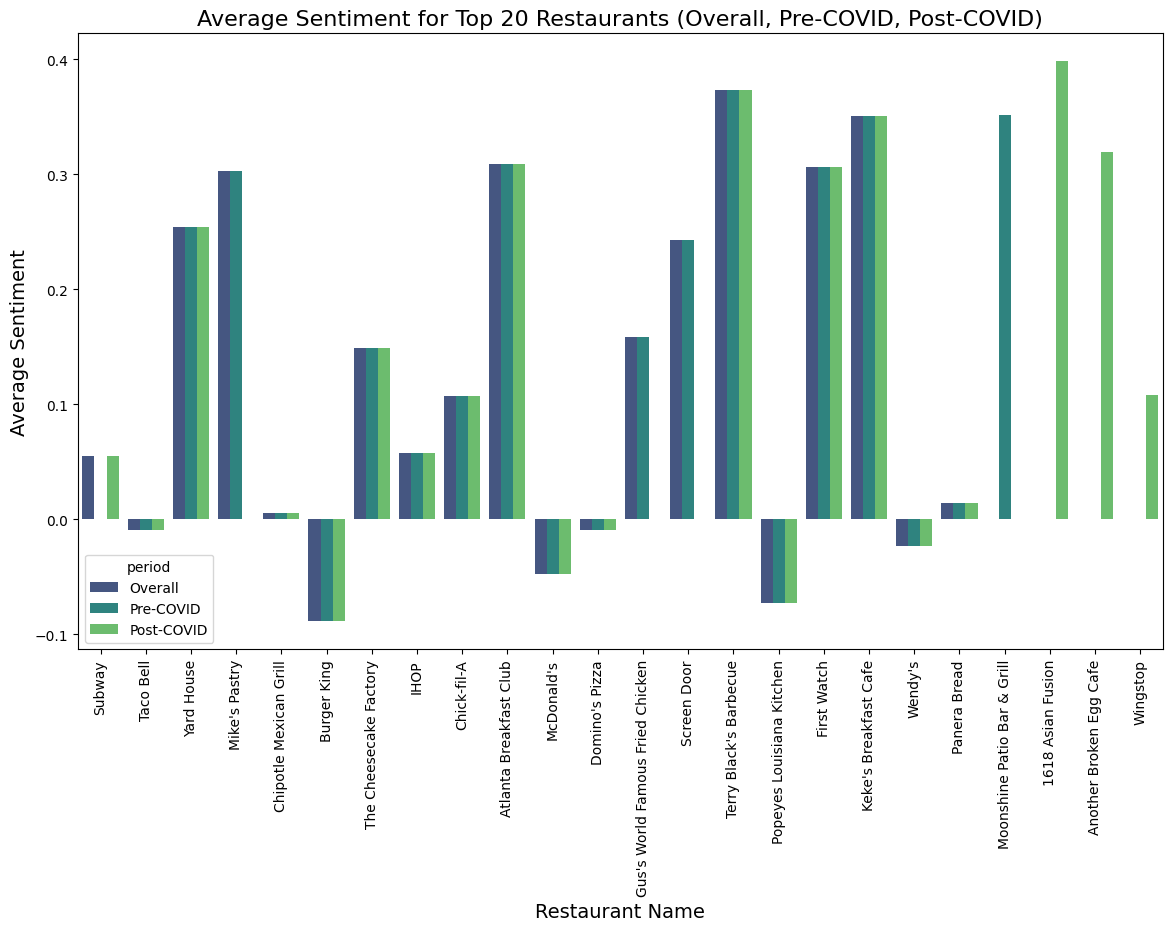

In [96]:
from pyspark.sql.functions import avg, col, lit, desc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get top 20 restaurants for a given period
def get_top_20_restaurants(df, period=None):
    if period:
        df_period = df.filter(df['period'] == period)
    else:
        df_period = df  # If no period is provided, use the entire dataframe
    
    top_20 = (df_period
              .groupBy('name')
              .count()
              .orderBy(desc('count'))
              .limit(20)
              .toPandas())
    
    top_20.columns = ['name', 'count']
    return top_20

# Extract top 20 restaurants for each period
top_20_overall = get_top_20_restaurants(df)  # Overall period
top_20_pre = get_top_20_restaurants(df, 'Pre-COVID')
top_20_post = get_top_20_restaurants(df, 'Post-COVID')

# Function to compute average sentiment for top 20 restaurants
def avg_sentiment_for_top_20(df, top_20):
    top_20_names = top_20['name'].tolist()
    df_top_20 = df.filter(df['name'].isin(top_20_names))
    
    avg_sentiment = (df_top_20
                     .groupBy('name')
                     .agg(avg('sentiment').alias('avg_sentiment'))
                     .toPandas())
    
    return avg_sentiment

# Compute average sentiment scores for top 20 restaurants
avg_sentiment_overall = avg_sentiment_for_top_20(df, top_20_overall)
avg_sentiment_pre = avg_sentiment_for_top_20(df, top_20_pre)
avg_sentiment_post = avg_sentiment_for_top_20(df, top_20_post)

# Add period column to each DataFrame
avg_sentiment_overall['period'] = 'Overall'
avg_sentiment_pre['period'] = 'Pre-COVID'
avg_sentiment_post['period'] = 'Post-COVID'

# Combine all sentiment data into one DataFrame
combined_sentiment_df = pd.concat([avg_sentiment_overall, avg_sentiment_pre, avg_sentiment_post])

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a seaborn bar plot
sns.barplot(data=combined_sentiment_df, x='name', y='avg_sentiment', hue='period', palette='viridis')

# Add titles and labels
plt.title('Average Sentiment for Top 20 Restaurants (Overall, Pre-COVID, Post-COVID)', fontsize=16)
plt.xlabel('Restaurant Name', fontsize=14)
plt.ylabel('Average Sentiment', fontsize=14)
plt.xticks(rotation=90)  # Rotate x labels for better readability

# Display the plot
plt.show()






In [97]:
# Combine all sentiment data into one DataFrame
combined_sentiment_df = pd.concat([avg_sentiment_overall, avg_sentiment_pre, avg_sentiment_post])

# Save the combined DataFrame to a CSV file
combined_sentiment_df.to_csv('average_sentiment_top_20_restaurants.csv', index=False)


In [102]:
i

0